# 🚘 Project 03: 자동차 모델 분류
---
## 주제: 자동차 모델 분류 (미세 조정 fine_tune (유사도 높은 데이터세트 탐색))
---
### 목표 (Target)
- **에스턴 마틴**
- **아우디**
- **벤틀리**
- **페라리**
- **혼다**
- **현대**
- **람보르기니**
- **렉서스**
- **로터스**
- **마세라티**
- **마즈다**
- **맥라렌**


### 목차
1. 데이터셋 불러오기.
2. 데이터 프레임으로 file 경로 및 target 분류.
3. fine_tuning을 통한 학습 시간의 효율적 확보.
4. 데이터 훈련.
5. 데이터 검증.
6. 결론.

## 1. 이미지 불러오기

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/p_brand_models_images_a/'

IMAGE_SIZE = 128
BATCH_SIZE = 64

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
print(generator.class_indices)

Found 535 images belonging to 12 classes.
{'aston-martin': 0, 'audi': 1, 'bentley': 2, 'ferrari': 3, 'honda': 4, 'hyundai': 5, 'lamborghini': 6, 'lexus': 7, 'lotus': 8, 'maserati': 9, 'mazda': 10, 'mclaren': 11}


In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'aston-martin',
 1: 'audi',
 2: 'bentley',
 3: 'ferrari',
 4: 'honda',
 5: 'hyundai',
 6: 'lamborghini',
 7: 'lexus',
 8: 'lotus',
 9: 'maserati',
 10: 'mazda',
 11: 'mclaren'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [4]:
import pandas as pd

c_df = pd.DataFrame({'file_paths': generator.filepaths,'target_names': target_names, 'targets': generator.classes})
c_df

,file_paths,target_names,targets
0,./datasets/p_brand_models_images_a/aston-marti...,aston-martin,0
1,./datasets/p_brand_models_images_a/aston-marti...,aston-martin,0
2,./datasets/p_brand_models_images_a/aston-marti...,aston-martin,0
3,./datasets/p_brand_models_images_a/aston-marti...,aston-martin,0
4,./datasets/p_brand_models_images_a/aston-marti...,aston-martin,0
...,...,...,...
530,./datasets/p_brand_models_images_a/mclaren/gt-...,mclaren,11
531,./datasets/p_brand_models_images_a/mclaren/gt-...,mclaren,11
532,./datasets/p_brand_models_images_a/mclaren/gt-...,mclaren,11
533,./datasets/p_brand_models_images_a/mclaren/gt-...,mclaren,11


In [5]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(c_df.file_paths, 
                 c_df.targets, 
                 stratify=c_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
10    64
7     56
5     56
1     52
3     52
4     44
0     24
11    20
9     20
2     16
8     12
6     12
Name: count, dtype: int64
targets
10    16
5     14
7     14
3     13
1     13
4     11
0      6
11     5
9      5
2      4
8      3
6      3
Name: count, dtype: int64


In [6]:
train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify = train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
10    51
7     45
5     45
1     41
3     41
4     35
0     19
9     16
11    16
2     13
6     10
8     10
Name: count, dtype: int64
targets
10    13
5     11
7     11
3     11
1     11
4      9
0      5
9      4
11     4
2      3
6      2
8      2
Name: count, dtype: int64
targets
10    16
5     14
7     14
3     13
1     13
4     11
0      6
11     5
9      5
2      4
8      3
6      3
Name: count, dtype: int64


## 2. 데이터 프레임 분리

In [8]:
train_df = c_df.iloc[train_images.index].reset_index(drop=True)
validation_df = c_df.iloc[validation_images.index].reset_index(drop=True)
test_df = c_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(342, 3)
(86, 3)
(107, 3)


## 3-0. 유사도를 확인하기 위해 사전 훈련 모델을 통한 이미지 데이터 확인
## 3-0-1. VGG 모델을 사용했을 때 차량 분류가 높은 사항으로 나와 유사도는 높다고 판단 후 추가 훈련 진행

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 1:
('n04285008', 'sports_car', 0.38817456)
sports_car 38.8175%


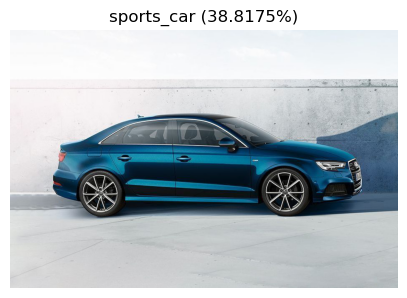



Image 2:
('n04009552', 'projector', 0.38206652)
projector 38.2067%


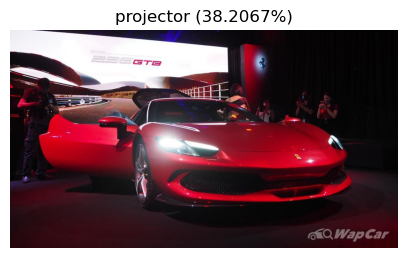



Image 3:
('n04037443', 'racer', 0.83090764)
racer 83.0908%


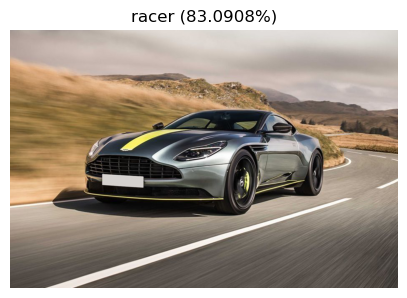



Image 4:
('n04037443', 'racer', 0.2792913)
racer 27.9291%


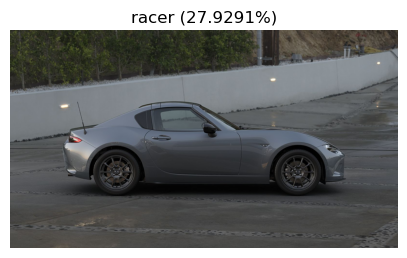

In [52]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions


import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications import ResNet50V2

# 모델을 로드합니다.
model = VGG16(weights='imagenet')

# 이미지를 로드하고 전처리하는 함수입니다.
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# 이미지 출력 함수 선언
def show_image_with_prediction(image, prediction):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    title = f'{prediction[1]} ({np.round(float(prediction[2]) * 100, 4)}%)'
    plt.title(title)
    plt.show()

# 이미지 파일 경로 리스트를 정의합니다.
image_paths = [
    './datasets/p_brand_models_images_a/audi/a3-sedan-1.jpg',
    './datasets/p_brand_models_images_a/ferrari/296-1.jpg',
    './datasets/p_brand_models_images_a/aston-martin/db11-0.jpg',
    './datasets/p_brand_models_images_a/mazda/mx-5-3.jpg'
]

# 이미지를 로드하고 배열로 변환합니다.
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# 예측을 수행합니다.
predictions = model.predict(images)

# 예측 결과를 디코딩하고 출력합니다.
for i, img_path in enumerate(image_paths):
    # 원본 이미지를 로드하고 색상 변환
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    prediction = decode_predictions(np.expand_dims(predictions[i], axis=0))
    
    # 예측 결과 출력 및 이미지 표시
    print(f"Image {i + 1}:")
    print(prediction[0][0])
    print(prediction[0][0][1], f'{np.round(prediction[0][0][2] * 100, 4)}%')
    
    show_image_with_prediction(image, prediction[0][0])
    print("\n")


## 3-1. 이미지의 개수가 적기 때문에 데이터셋 미세조정 및 albumentation.
## 3-1-1.fine_tuning 을 통한 분류기만 훈련 진행

In [53]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 128
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)
                    
            results_batch[i] = image

        return results_batch, targets_batch
        
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [70]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(12, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [75]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 128
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 부분 freeze 진행
    # for layer in model.layers[:85]:
    #     layer.trainable = False
    
    model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [76]:
model = create_model()
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,950 (56.23 MB)

 Trainable params: 14,740,950 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# freeze 확인하기
for i, layer in enumerate(model.layers[:-3]):
    layer.trainable = False
    print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

print('\n######### classifier layers ######### ')
for layer in model.layers[-3:]:
    print(layer.name, 'trainable:', layer.trainable)

1 . input_layer_13 trainable: False
2 . block1_conv1 trainable: False
3 . block1_conv2 trainable: False
4 . block1_pool trainable: False
5 . block2_conv1 trainable: False
6 . block2_conv2 trainable: False
7 . block2_pool trainable: False
8 . block3_conv1 trainable: False
9 . block3_conv2 trainable: False
10 . block3_conv3 trainable: False
11 . block3_pool trainable: False
12 . block4_conv1 trainable: False
13 . block4_conv2 trainable: False
14 . block4_conv3 trainable: False
15 . block4_pool trainable: False
16 . block5_conv1 trainable: False
17 . block5_conv2 trainable: False
18 . block5_conv3 trainable: False
19 . block5_pool trainable: False

######### classifier layers ######### 
global_average_pooling2d_11 trainable: True
dense_11 trainable: True
output trainable: True


In [78]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,950 (56.23 MB)

 Trainable params: 14,740,950 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - acc: 0.0663 - loss: 12.6497 - val_acc: 0.1279 - val_loss: 9.5697
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - acc: 0.0998 - loss: 6.7680 - val_acc: 0.1977 - val_loss: 6.6545
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - acc: 0.1882 - loss: 4.9672 - val_acc: 0.1744 - val_loss: 4.9934
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - acc: 0.2035 - loss: 3.7499 - val_acc: 0.2326 - val_loss: 4.0467
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - acc: 0.2426 - loss: 3.0035 - val_acc: 0.1977 - val_loss: 3.4325
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - acc: 0.2877 - loss: 2.5687 - val_acc: 0.2442 - val_loss: 3.0884
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.2867 - loss: 2.3243 - val_acc: 0.2442 - val_loss: 2.8333
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.2797 - loss: 2.3274 - val_acc: 0.2791 - val_loss: 2.6586
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.3198 - loss: 2.1447 - val_acc: 0.2791 - v

## 3-1-2. 분류기만 훈련이 진행되었을 때 점수가 낮기 때문에 전체 훈련 데이터에 대하여 다시 진행 해볼것

In [79]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 128
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 전체 unfreeze 진행
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [80]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,950 (56.23 MB)

 Trainable params: 14,740,950 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - acc: 0.1008 - loss: 12.3634 - val_acc: 0.1628 - val_loss: 8.3178
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - acc: 0.1521 - loss: 7.4015 - val_acc: 0.1512 - val_loss: 6.2918
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - acc: 0.1565 - loss: 5.9088 - val_acc: 0.1279 - val_loss: 5.2382
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - acc: 0.1861 - loss: 4.2479 - val_acc: 0.1512 - val_loss: 4.1556
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - acc: 0.2419 - loss: 3.5484 - val_acc: 0.2093 - val_loss: 3.4655
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.2182 - loss: 3.0492 - val_acc: 0.2093 - val_loss: 3.0708
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.2520 - loss: 2.6347 - val_acc: 0.2209 - val_loss: 2.8114
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.3016 - loss: 2.4544 - val_acc: 0.2093 - val_loss: 2.6454
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.3359 - loss: 2.0886 - val_acc:

## 3-1-3. Batch size 를 조정해서 epoch 당 훈련 횟수를 증가 및 훈련 횟수 증가, 규제를 추가하여 과적합 방지 

In [85]:
import gc

gc.collect()

2489

In [86]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', kernel_regularizer=l2(1e-4))(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(12, activation='softmax',  name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [87]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 128
BATCH_SIZE = 16

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 전체 unfreeze 진행
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [88]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,950 (56.23 MB)

 Trainable params: 14,740,950 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 816ms/step - acc: 0.0955 - loss: 9.9824 - val_acc: 0.1860 - val_loss: 5.1468
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 820ms/step - acc: 0.1733 - loss: 4.2870 - val_acc: 0.1860 - val_loss: 3.2359
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 994ms/step - acc: 0.2216 - loss: 2.7102 - val_acc: 0.2209 - val_loss: 2.8117
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 886ms/step - acc: 0.2902 - loss: 2.2860 - val_acc: 0.2326 - val_loss: 2.5911
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 856ms/step - acc: 0.3095 - loss: 2.1591 - val_acc: 0.2209 - val_loss: 2.5672
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 825ms/step - acc: 0.3053 - loss: 1.9874 - val_acc: 0.2674 - val_loss: 2.7207
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 824ms/step - acc: 0.3800 - loss: 1.8935 - val_acc: 0.2558 - val_loss: 2.6762
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 839ms/step - acc: 0.4010 - loss: 1.6991 - val_acc: 0.2558 - val_loss: 2.6880
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 856ms/

## 3-1-4. 과적합이 지속적으로 발생하여 callback 추가 및 모델 일반화를 위한 dropout 1개 추가

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [96]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': 
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': 
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(rate=0.2)(x)
    
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(12, activation='softmax',  name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [97]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 64
BATCH_SIZE = 16

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 전체 unfreeze 진행
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset
            )
    
    return model, history

In [98]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,950 (56.23 MB)

 Trainable params: 14,740,950 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - acc: 0.0896 - loss: 21.5902 - val_acc: 0.1395 - val_loss: 9.7401
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - acc: 0.2056 - loss: 9.2057 - val_acc: 0.1628 - val_loss: 6.0944
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - acc: 0.1889 - loss: 5.1501 - val_acc: 0.0698 - val_loss: 4.0687
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - acc: 0.1979 - loss: 2.9449 - val_acc: 0.0930 - val_loss: 3.4310
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - acc: 0.2297 - loss: 2.5624 - val_acc: 0.1047 - val_loss: 3.0912
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - acc: 0.2177 - loss: 2.5876 - val_acc: 0.1163 - val_loss: 2.9417
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - acc: 0.2357 - loss: 2.3784 - val_acc: 0.1279 - val_loss: 2.8817
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - acc: 0.2585 - loss: 2.2707 - val_acc: 0.1628 - val_loss: 2.8002
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - a